# Deutsch-Josza algorithm

#### Problem: find whether the Boolean function $f(x):\{0,1\}^n\rightarrow\{0,1\}$ is constant or balanced 

### Import section

In [3]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import *
import numpy as np
from math import pi

from qiskit_aer import StatevectorSimulator, QasmSimulator, UnitarySimulator

### 1. Set length of first register and oracle

In [19]:
n = 4

# set the oracle: b for balanced, c for constant
oracle = "b"

# if the oracle is balanced, set the hidden bitstring, b
if oracle == "b":
    b = np.random.randint(1,2**n) # you can choose  the number 
    display(b)
# if the oracle is constant, set c = 0 or 1 randomly.
if oracle == "c":
    c = np.random.randint(2)
    display(c)
    

10

### 2. Initialize first register in $|+\rangle^{\otimes n}$, second register (1 qubit) in $|-\rangle$ 

In [20]:
qc = QuantumCircuit(n+1,n)
qc.x(n)

# Apply Hadamard gates to all qubits
qc.h(range(n+1))

qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 4)), clbits=())

### 3. Construct oracle function 

In [21]:
if oracle == "c":
    if c == 1:
        qc.x(n)
    else:
        qc.id(n)
else:
    # the random number b tells us which CNOTs to wrap in X-gates:
    
    # Next, format 'b' as a binary string of length 'n', padded with zeros:
    b_str = format(b, '0'+str(n)+'b')
    # Next, we place the first X-gates. Each digit in our binary string 
    # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1 we apply an X-gate to that qubit:
    for qubit in range(len(b_str)):
        if b_str[qubit] == '1':
            qc.x(qubit)
    # Do the controlled-NOT gates for each qubit, using the output qubit as the target:
    for qubit in range(n):
        qc.cx(qubit, n)
    # Next, place the final X-gates
    for qubit in range(len(b_str)):
        if b_str[qubit] == '1':
            qc.x(qubit)
            
qc.barrier()            

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 4)), clbits=())

In [22]:
b_str

'1010'

### 3. Measure in X-basis the first register

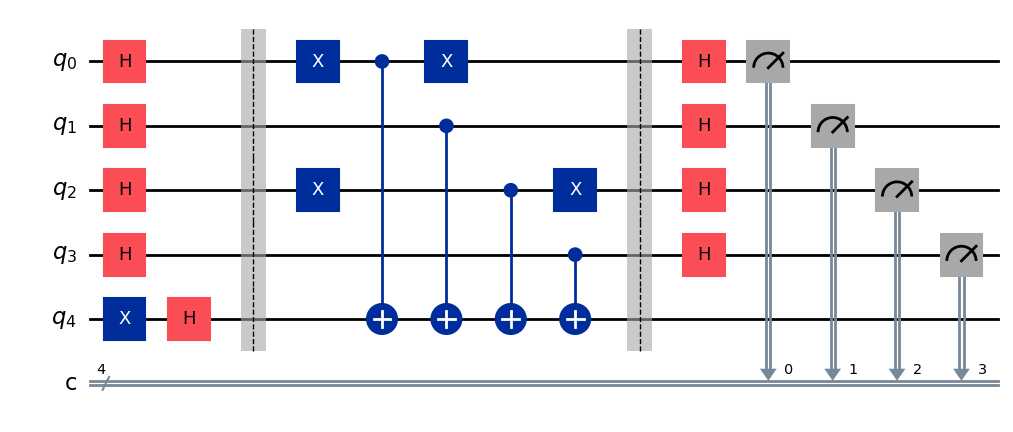

In [23]:
# apply Hadamard gates to the first register
qc.h(range(n))  
qc.measure(range(n),range(n))

qc.draw('mpl')

{'1111': 1}


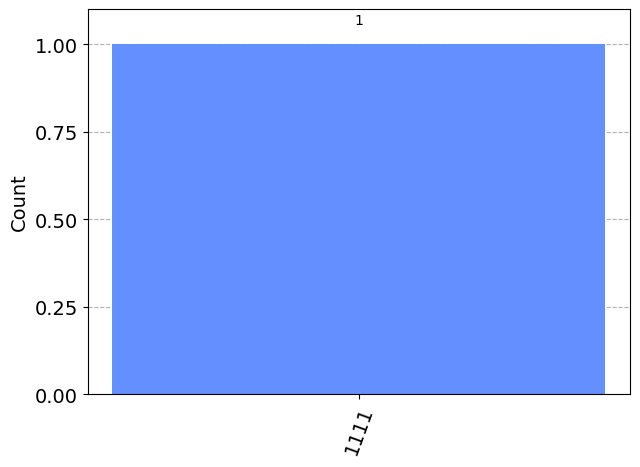

In [24]:
# use local simulator
backend = QasmSimulator()
counts = backend.run(qc,shots = 1).result().get_counts()
print(counts)
plot_histogram(counts)

## Run on real hardware

In [25]:
service = QiskitRuntimeService(channel='ibm_quantum',token='306055f5468349ef546991ac6e3b356f40d9190d9b50bf98b793de3cd71cd832d3eca2174ee7ed24e743ec7c1685550b13a7ddfabc01501d55b5030019a760ee')
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_oslo')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>]

In [27]:
# get the least-busy backend at IBM and run the quantum circuit there
#backend = service.least_busy(simulator=False,operational=True)
backend = service.backend('ibm_kyoto')

job = backend.run(qc,shots = 8192)

In [28]:
# check job status
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [ ]:
counts = job.result().get_counts()
print(counts)
plot_histogram(counts)

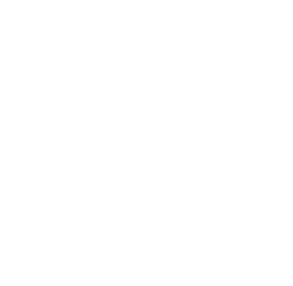

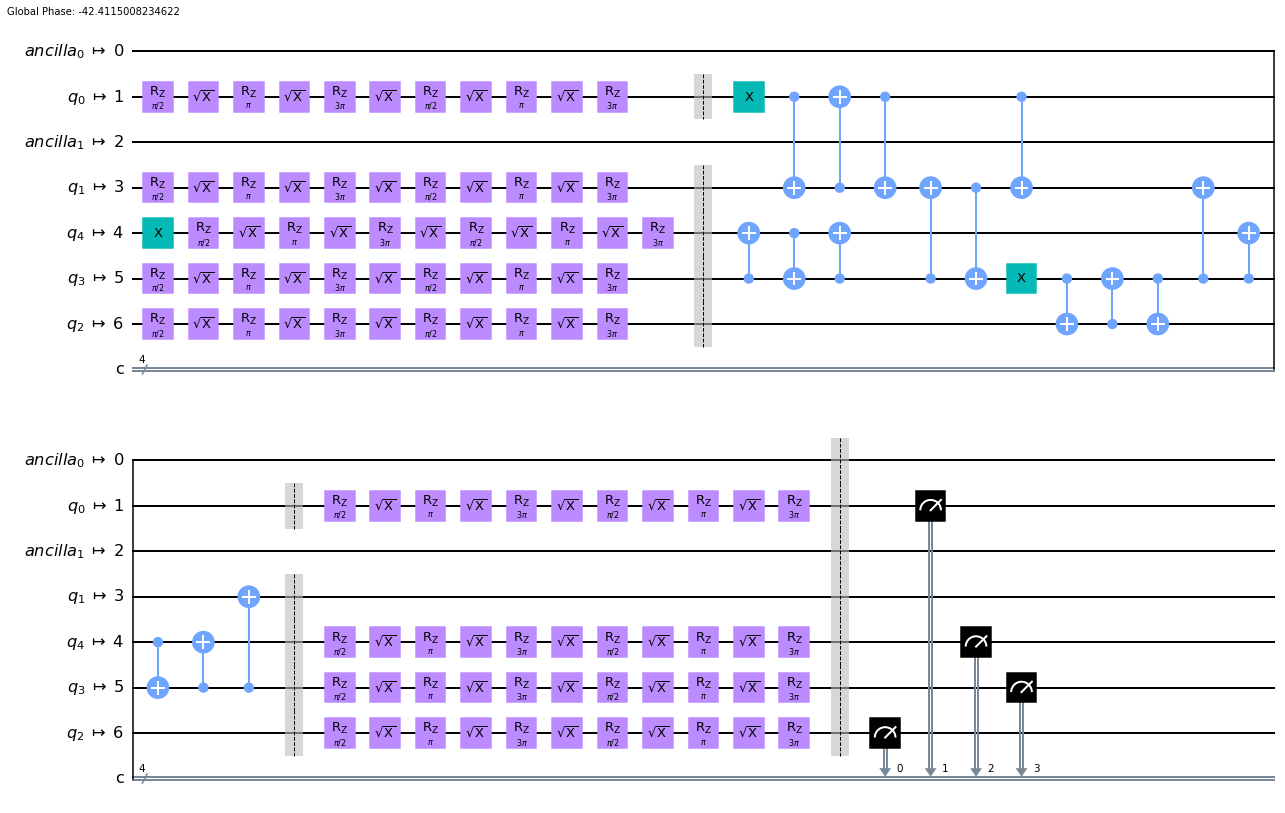

gates =  OrderedDict([('rz', 54), ('sx', 45), ('cx', 17), ('measure', 4), ('x', 3), ('barrier', 3)])
depth =  39


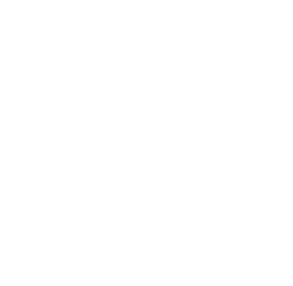

In [35]:
from qiskit.visualization import plot_circuit_layout

backend = provider.get_backend('ibm_perth')

new_circ_lv0 = transpile(qc, backend=backend, optimization_level=1)
display(plot_circuit_layout(new_circ_lv0, backend))

display(new_circ_lv0.draw('mpl'))
print('gates = ', new_circ_lv0.count_ops())
print('depth = ', new_circ_lv0.depth())

Job Status: job has successfully run
{'0000': 248, '0001': 153, '0010': 73, '0011': 236, '0100': 50, '0101': 140, '0110': 67, '0111': 677, '1000': 144, '1001': 165, '1010': 107, '1011': 601, '1100': 142, '1101': 595, '1110': 461, '1111': 4333}


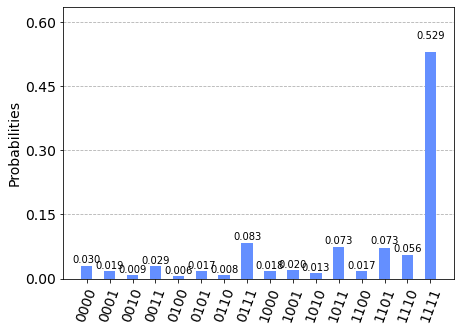

In [13]:
job_exp_transpiled = execute(new_circ_lv0, backend=backend, shots=8192, initial_layout=[4,3,2,1,0])

job_monitor(job_exp_transpiled)

# Get the results and display them
exp_result = job_exp_transpiled.result()
exp_measurement_result = exp_result.get_counts(qc)

print(exp_measurement_result)
plot_histogram(exp_measurement_result)